In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

df_org = pd.read_csv('./kaggle/house/train.csv')

In [11]:
df = df_org.copy()
df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [27]:
isnull_series = df.isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
BsmtExposure    38
BsmtFinType2    38
BsmtQual        37
BsmtCond        37
BsmtFinType1    37
MasVnrType       8
Electrical       1
dtype: int64

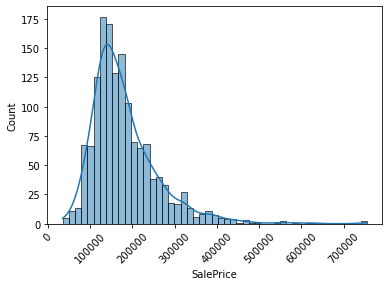

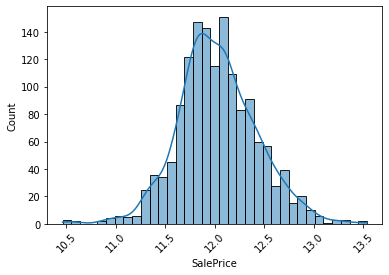

In [18]:
plt.xticks(rotation=45)
sns.histplot(df['SalePrice'], kde=True)
plt.show()

plt.xticks(rotation=45)
log_SalePrice = np.log1p(df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [23]:
df = df_org.copy()
org_SalePrice = df['SalePrice']
df['SalePrice'] = np.log1p(df['SalePrice'])
df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,12.072547
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,12.254868
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,12.493133
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,11.864469


In [26]:
df.fillna(df.mean(), inplace=True)


In [32]:
null_column_count = df.isnull().sum()[df.isnull().sum() > 0]
df.dtypes[null_column_count.index]
# null_column_count

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [35]:
df_ohe = pd.get_dummies(df)

In [74]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, 'RMSE: {}'.format(np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ + ' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{} CV RMSE 값 리스트: {}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{} CV 평균 RMSE 값: {}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, Y)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{} 5 CV 시 최적 평균 RMSE 값: {}, 최적 alpha:{}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__ + ' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index, ax=axs[i_num])

def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(Y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{} 모델의 RMSE: {}'.format(key, rmse))


# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, Y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    # kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__ , ' model 시작')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index] 
        Y_tr = Y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , Y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [49]:
Y = df_ohe['SalePrice']
X = df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, Y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, Y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, Y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression RMSE: 0.132
Ridge RMSE: 0.128
Lasso RMSE: 0.176


[0.1318957657915454, 0.1275084633405305, 0.17628250556471395]


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


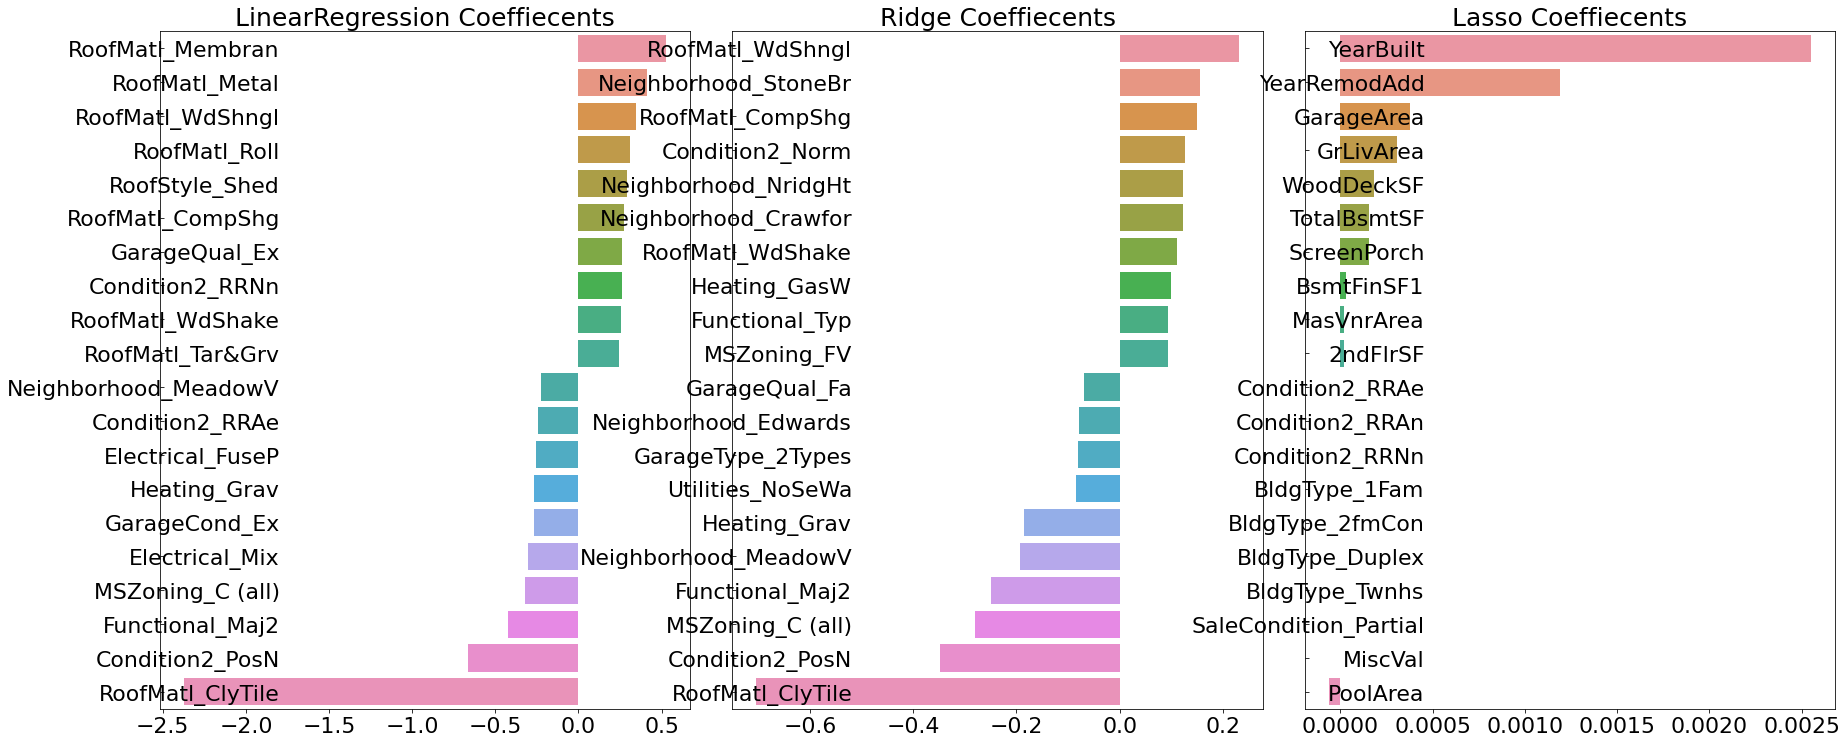

In [50]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
get_avg_rmse_cv(models)

In [51]:
# 하이퍼파라미터 튜닝

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression RMSE: 0.132
Ridge RMSE: 0.124
Lasso RMSE: 0.12


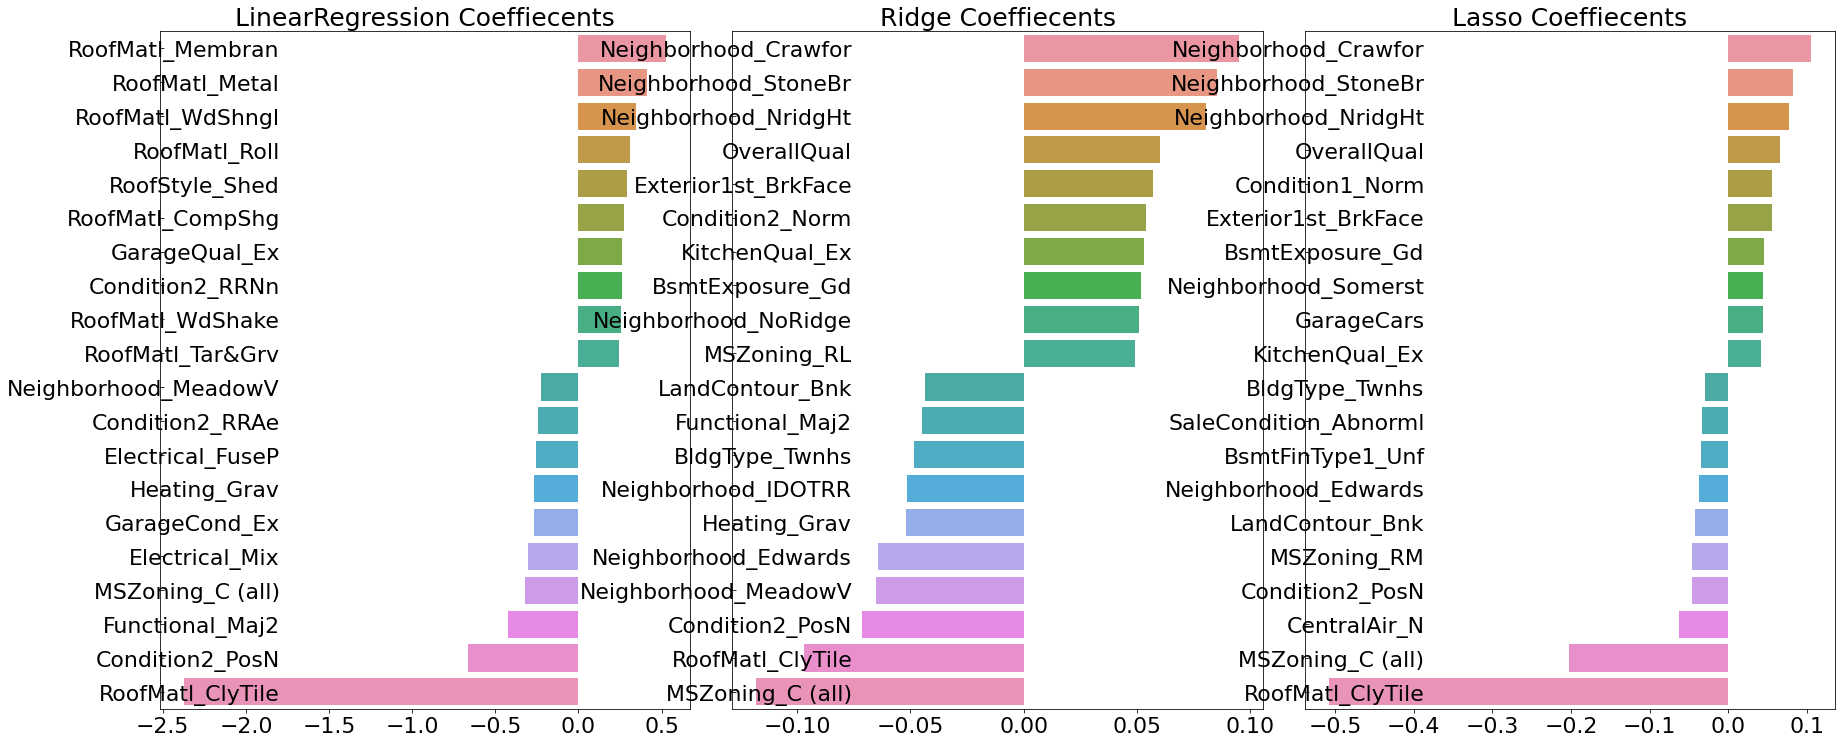

In [52]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, Y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, Y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, Y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [56]:
# 데이터 왜곡 로그 변환 후 성능 평가

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = df.dtypes[df.dtypes != 'object'].index
# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = df[features_index].apply(lambda x : skew(x))
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
df_ohe = pd.get_dummies(df)
Y = df_ohe['SalePrice']
X = df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1276, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1251, 최적 alpha:{'alpha': 0.001}


LinearRegression RMSE: 0.129
Ridge RMSE: 0.121
Lasso RMSE: 0.117


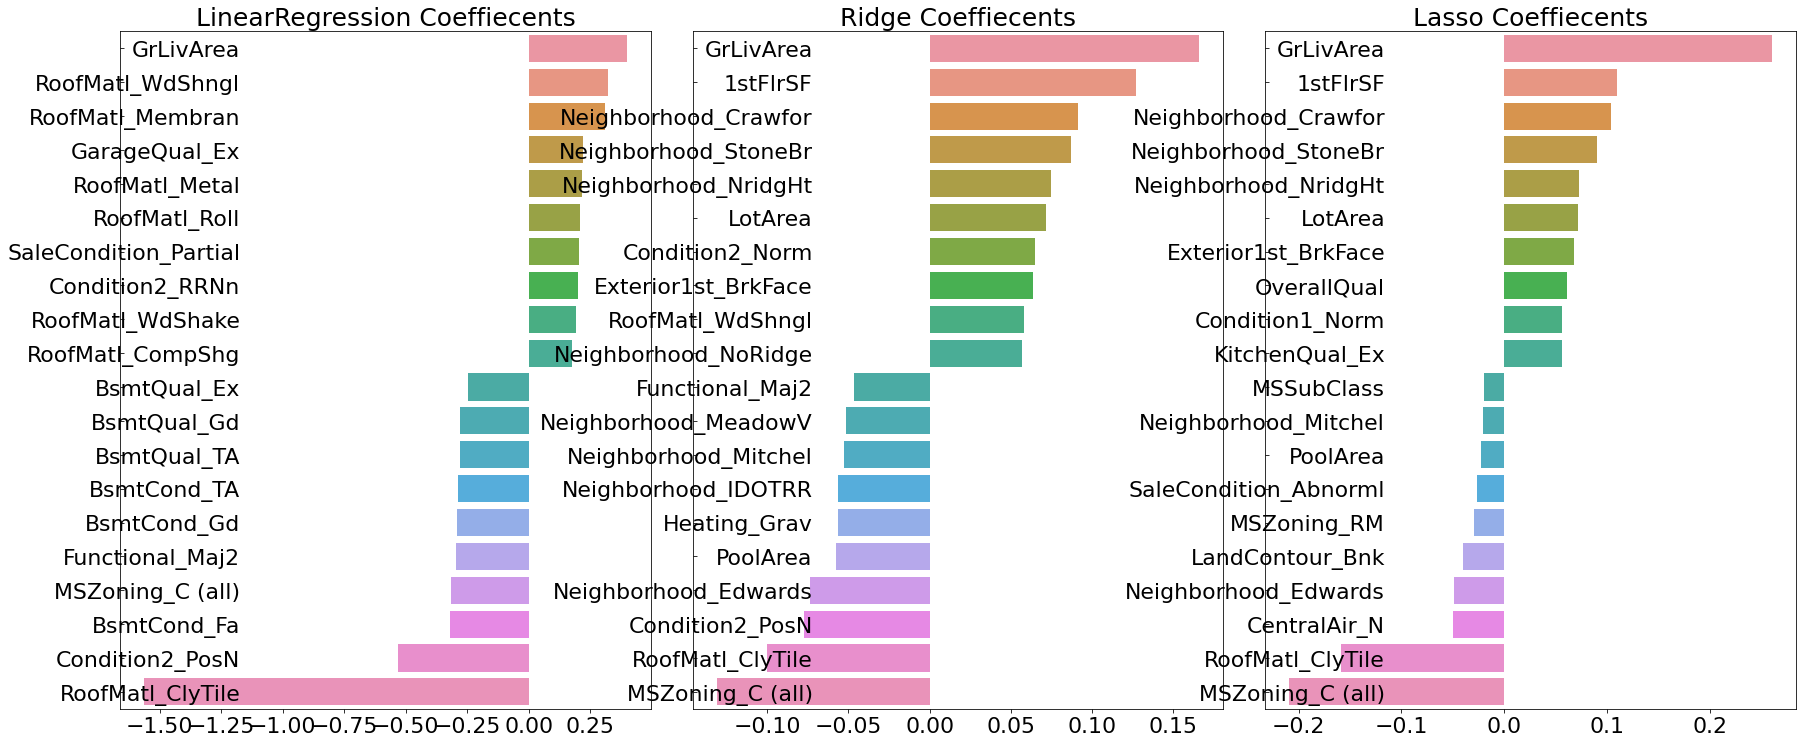

In [57]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, Y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, Y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, Y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

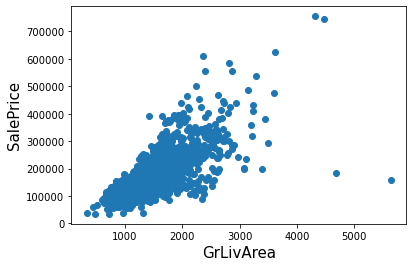

In [58]:
# 이상치 제거

plt.scatter(x=df_org['GrLivArea'], y=df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [59]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [60]:
Y = df_ohe['SalePrice']
X = df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


LinearRegression RMSE: 0.129
Ridge RMSE: 0.103
Lasso RMSE: 0.1


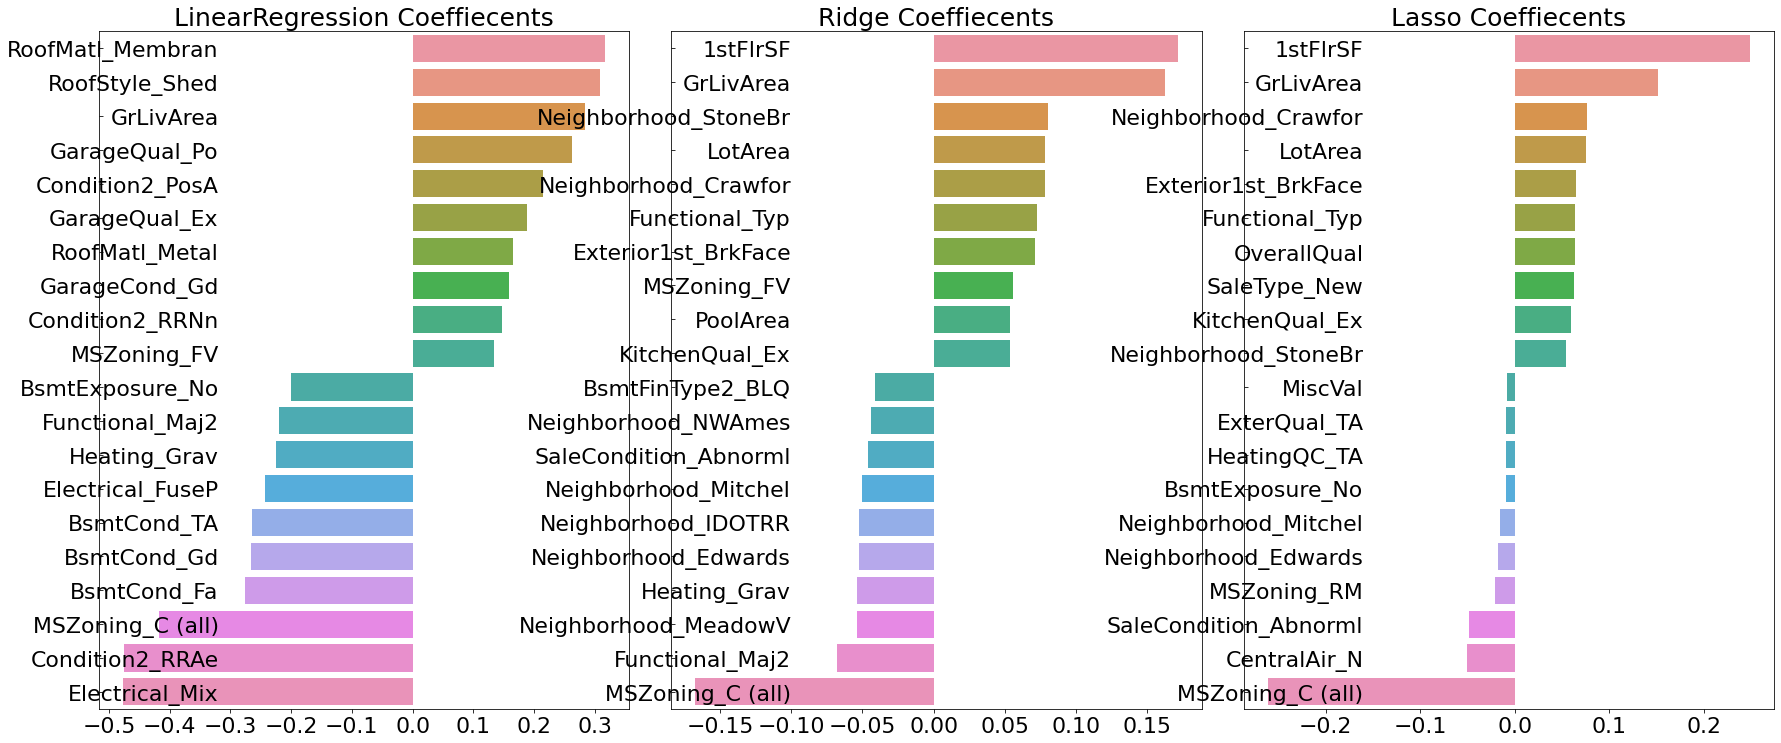

In [61]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, Y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, Y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, Y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [62]:
# 회귀 트리 학습 / 예측 / 평가

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1178, 최적 alpha:{'n_estimators': 1000}


In [63]:
lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1163, 최적 alpha:{'n_estimators': 1000}


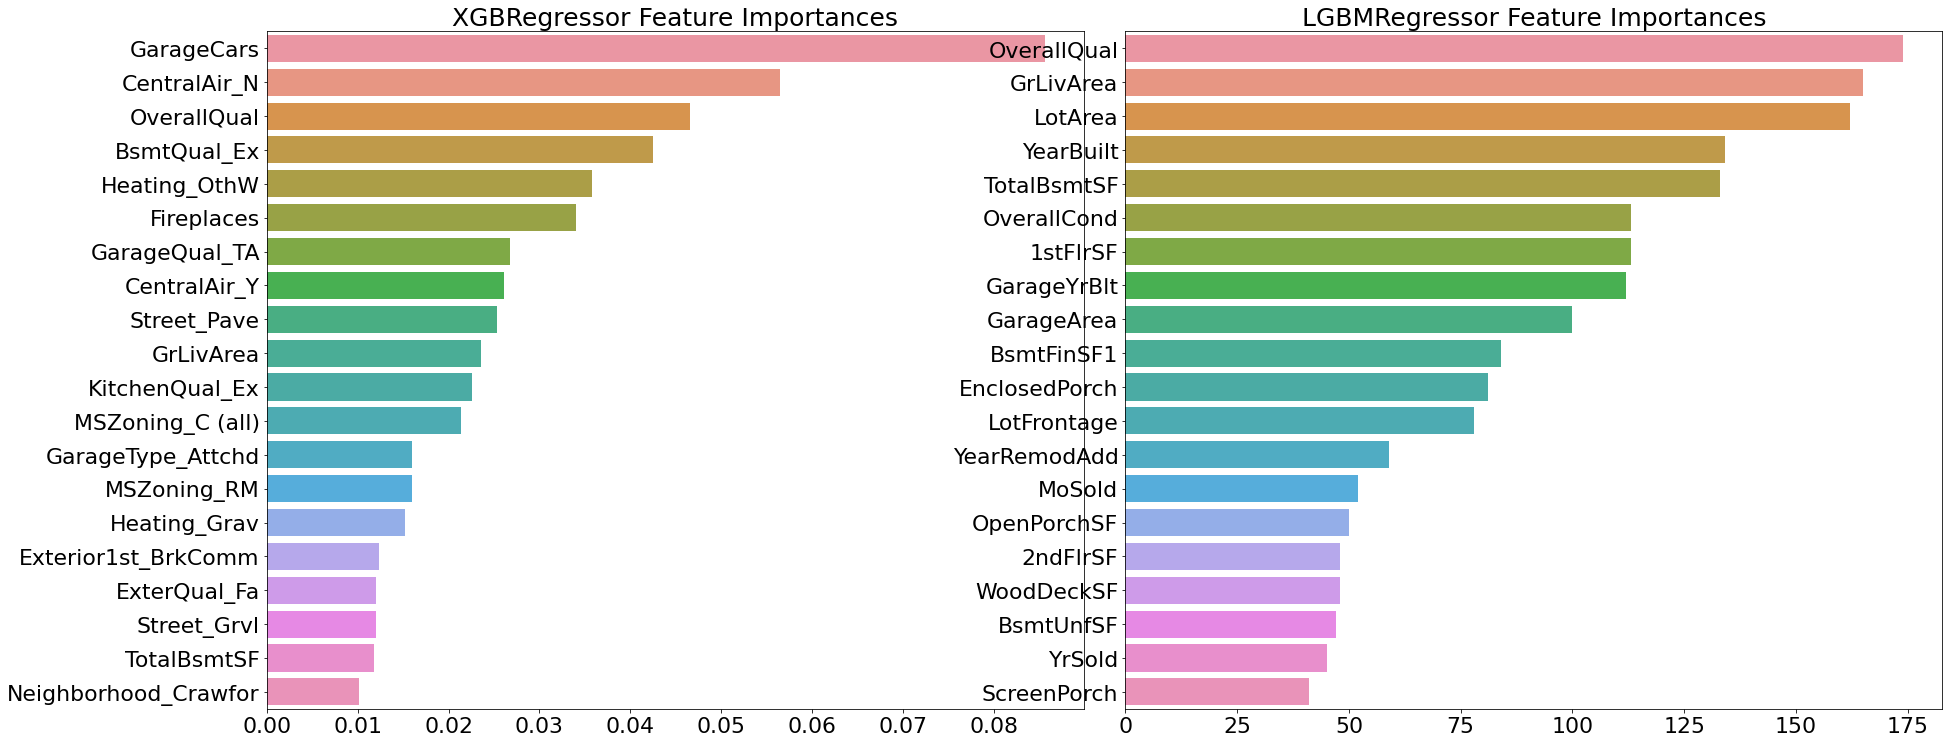

In [66]:
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

In [68]:
# 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, Y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, Y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.09970842737250557
Ridge 모델의 RMSE: 0.1031329941208263
Lasso 모델의 RMSE: 0.09991843167945538


In [69]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                        subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, Y_train)
lgbm_reg.fit(X_train, Y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
        'XGBM': xgb_pred,
        'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10170077353447762
XGBM 모델의 RMSE: 0.10738295638346222
LGBM 모델의 RMSE: 0.10382510019327311


In [75]:
# 스태킹 모델을 통한 회귀 예측

# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
Y_train_n = Y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, Y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, Y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, Y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, Y_train_n, X_test_n, 5)


Ridge  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
Lasso  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
XGBRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
LGBMRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작


In [76]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, Y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(Y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은: ', rmse)

스태킹 회귀 모델의 최종 RMSE 값은:  0.09825854907997045
